# PART A

# Imports

In [124]:
import pandas as pd
import numpy as np
import empyrical as ep
import statsmodels.api as sm
import seaborn as sns

from matplotlib import pyplot as plt
from scipy.optimize import minimize
from pathlib import Path
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

# Data

In [125]:
# Read Data - 10 Industry Portfolios
file_path = str(Path().absolute()) + "\Data\\10_Industry_Portfolios.CSV"
df = pd.read_csv(file_path, skiprows=11, nrows=1182, index_col = 0)
nb_industries = pd.read_csv(file_path, skiprows=2587, nrows=1182, index_col = 0)
avg_size = pd.read_csv(file_path, skiprows=3773, nrows=1182, index_col = 0)


# Read Data - 10 Industry Portfolios
file_path = str(Path().absolute()) + "\Data\\F-F_Research_Data_Factors_Clean.CSV"
rf = pd.read_csv(file_path, index_col = 0)


# Extract last column in the data frame - monthly risk free rate
exc_mkt = rf.loc[:, 'Mkt-RF']
rf = rf.loc[:, 'RF']


# Convert index column into a date format
df.index = pd.to_datetime(df.index, format ="%Y%m")
nb_industries.index = pd.to_datetime(nb_industries.index, format ="%Y%m")
avg_size.index = pd.to_datetime(avg_size.index, format ="%Y%m")
rf.index = pd.to_datetime(rf.index, format ="%Y%m")
exc_mkt.index = pd.to_datetime(exc_mkt.index, format ="%Y%m")


df = df/100
exc_mkt = exc_mkt/100
df.head()


,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
1926-07-01,0.0145,0.1555,0.0469,-0.0118,0.0290,0.0083,0.0011,0.0177,0.0704,0.0213
1926-08-01,0.0397,0.0368,0.0281,0.0347,0.0266,0.0217,-0.0071,0.0425,-0.0169,0.0435
1926-09-01,0.0114,0.0480,0.0115,-0.0339,-0.0038,0.0241,0.0021,0.0069,0.0204,0.0029
1926-10-01,-0.0124,-0.0823,-0.0363,-0.0078,-0.0458,-0.0011,-0.0229,-0.0057,-0.0263,-0.0284
1926-11-01,0.0520,-0.0019,0.0410,0.0001,0.0471,0.0163,0.0643,0.0542,0.0371,0.0211


# Question 1

Define all portfolio and performance functions

In [126]:
def neg_sharpe_ratio(w: np.array, sigma: np.array, mean: np.array, rf: float):
    """
    computes sharpe ratio of portfolio
    :param w: weights of each asset in portfolio (no risk free-asset)
    :param sigma: variance-covariance matrix of portfolio assets (no risk-free asset)
    :param mean: average excess returns of assets (no risk-free asset)
    :param rf: risk-free rate
    :return: sharpe of portfolio
    """

    return -1 * (w @ (mean - rf)) / np.sqrt(w @ sigma @ w)


def max_sharpe(df, rf, long_only=False):
    """
    computes max sharpe ratio
    :param df: dataframe of returns
    :param rf: dataframe of risk-free rate
    :param long_only: boolean to specify if there are short-sale constraints

    """
    sigma = df.cov()
    mu = df.mean(axis=0)

    if long_only:

        # constraints and bounds on optimization
        cons = ({"type": "eq", "fun": lambda x: np.sum(x) - 1})  # weights must sum to 1
        bounds = []
        for i in range(len(mu)):
            bounds.append((0, None))

        bounds = tuple(bounds)

        # initial weights
        init_w = np.full(shape=len(mu), fill_value=1 / len(mu))

        # optimization procedure
        w = minimize(neg_sharpe_ratio, init_w,
                     (sigma, mu, rf),
                     constraints=cons,
                     bounds=bounds,
                     method="SLSQP").x

    else:

        inv_sigma = np.linalg.inv(sigma)
        ones = np.ones(len(mu))

        B = mu.T @ inv_sigma @ ones
        A = ones.T @ inv_sigma @ ones

        w = inv_sigma @ (mu - rf) / (B - A * rf)

    return w


def inv_var(df):
    """
    computes weights inversely related to its variance
    :param df: dataframe of returns

    """

    w = (1 / df.var(axis=0)) / sum(1 / df.var(axis=0))
    return w


def inv_vol(df):
    """
    computes weights inversely related to its volatility
    :param df: dataframe of returns

    """

    w = (1 / df.std(axis=0)) / sum(1 / df.std(axis=0))
    return w


def equal_weight(df):
    """
    computes equal weights
    :param df: dataframe of returns

    """

    return np.full(len(df.columns), fill_value=1 / len(df.columns))


def mkt_weight(avg_size, nb_industries):
    """
    computes weights that are linearly related to market cap
    :param avg_size: dataframe including size of each industry
    :param nb_industries: dataframe including number of industries (under each category)

    """

    mkt_weights = avg_size * nb_industries
    mkt_weights = mkt_weights / mkt_weights.sum()

    return mkt_weights


def min_var(df):
    """
    computes minimum varaince
    :param  df: dataframe of returns
    
    """

    sigma = df.cov()
    inv_sigma = np.linalg.inv(sigma)
    ones = np.ones(len(df.columns))

    w = inv_sigma @ ones / (ones.T @ inv_sigma @ ones)

    return w


# Function to compute Jensen's alpha and Treynors Ratio
def jensens_alpha_treynor(excess_return, excess_market):
    """
    computes Jensen's Alpha and Treynors ratio for a portfolio.
    Parameters:
    :excess_return: DataFrame of excess portfolio returns (columns = portfolio)
    :excess_market: Series of market returns

    """

    # Compute mean excess returns
    mean_excess_return = np.sqrt(12) * excess_return.mean(axis=0)
    mean_excess_market = np.sqrt(12) * excess_market.mean()

    results = {}
    for portfolio in excess_return.columns:
        y = excess_return[portfolio].dropna()
        x = excess_market.loc[y.index].dropna()

        # Align data
        aligned = pd.concat([y, x], axis=1).dropna()
        if aligned.empty:
            results[portfolio] = np.nan
            continue

        # Regression to find Beta
        X = sm.add_constant(aligned.iloc[:, 1].values.reshape(-1, 1))  # Market excess return (2D)
        model = sm.OLS(aligned.iloc[:, 0].values, X).fit()

        beta = model.params[1]  # Market Beta
        alpha = mean_excess_return[portfolio] - beta * mean_excess_market  # Jensen’s Alpha (Intercept)
        treynor_ratio = mean_excess_return[portfolio] / beta if beta != 0 else np.nan # Treynor Ratio

        results[portfolio] = {"Jensen's Alpha": alpha, "Treynor's Ratio": treynor_ratio}


    return pd.DataFrame(results).T


Compute the portfolio returns based on the weights specified above

In [127]:
lookback = 59

backtest = pd.DataFrame(index=df.index,
                        columns=["max_sharpe", "max_sharpe_long_only", "inv_var", "inv_vol", "equal_weight",
                                 "mkt_weight", "min_var"])

for i in tqdm(range(59, df.shape[0] - 1)):
    start = df.index[i - lookback]
    end = df.index[i]
    current = df.index[i + 1]

    backtest.loc[current, "max_sharpe"] = df.loc[current, :] @ max_sharpe(df.loc[start:end, :], rf=rf.loc[end],
                                                                          long_only=False)
    backtest.loc[current, "max_sharpe_long_only"] = df.loc[current, :] @ max_sharpe(df.loc[start:end, :],
                                                                                    rf=rf.loc[end], long_only=True)
    backtest.loc[current, "inv_vol"] = df.loc[current, :] @ inv_vol(df.loc[start:end, :])
    backtest.loc[current, "inv_var"] = df.loc[current, :] @ inv_var(df.loc[start:end, :])
    backtest.loc[current, "equal_weight"] = df.loc[current, :] @ equal_weight(df.loc[start:end, :])
    backtest.loc[current, "mkt_weight"] = df.loc[current, :] @ mkt_weight(avg_size.loc[end, :],
                                                                          nb_industries.loc[end, :])
    backtest.loc[current, "min_var"] = df.loc[current, :] @ min_var(df.loc[start:end, :])

backtest

100%|██████████████████████████████████████████████████████████████████████████████| 1122/1122 [00:12<00:00, 86.37it/s]


,max_sharpe,max_sharpe_long_only,inv_var,inv_vol,equal_weight,mkt_weight,min_var
1926-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2024-08-01,0.060407,-0.0516,0.030493,0.02474,0.01575,0.020937,0.060453
2024-09-01,0.012477,0.1424,0.022863,0.025927,0.03135,0.021779,0.010506
2024-10-01,-0.009441,-0.0314,-0.011036,-0.010126,-0.01015,-0.005893,-0.009608
2024-11-01,0.002345,0.2968,0.056495,0.066896,0.08412,0.068554,0.00154


In [128]:
# the first 5 years are NA and must be dropped
backtest = backtest.dropna()

# Compute excess returns to used in the Performance Metrics 
excess = backtest.sub(rf, axis = 0)

excess

,max_sharpe,max_sharpe_long_only,inv_var,inv_vol,equal_weight,mkt_weight,min_var
1926-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2024-08-01,-0.419593,-0.5316,-0.449507,-0.45526,-0.46425,-0.459063,-0.419547
2024-09-01,-0.387523,-0.2576,-0.377137,-0.374073,-0.36865,-0.378221,-0.389494
2024-10-01,-0.399441,-0.4214,-0.401036,-0.400126,-0.40015,-0.395893,-0.399608
2024-11-01,-0.397655,-0.1032,-0.343505,-0.333104,-0.31588,-0.331446,-0.39846


Text(0.5, 1.0, 'Monthly Returns (Excluding Unconstrained Max Sharpe)')

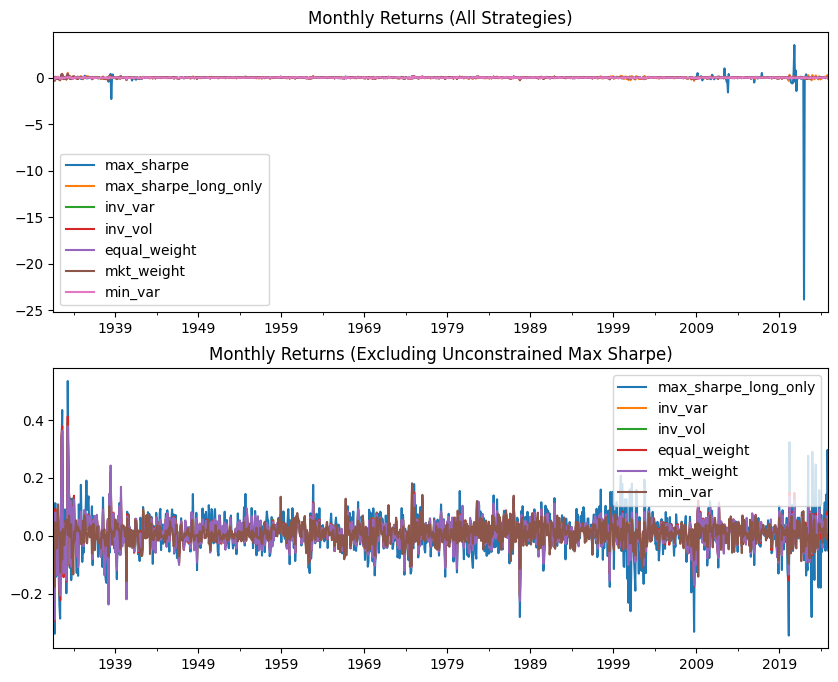

In [129]:
# plot monthly returns series
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

backtest.plot(ax=axes[0])
axes[0].set_title('Monthly Returns (All Strategies)')

backtest.drop('max_sharpe', axis=1).plot(ax=axes[1])
axes[1].set_title('Monthly Returns (Excluding Unconstrained Max Sharpe)')

In [130]:
# Drop NAs in excess return and rf/100
excess_return = backtest.sub(rf/100, axis = 0).dropna()

# Comparison of Performance

In [131]:
# periods of interest
periods = {
    'Jul 1931 - Dec 2025': ('1931-07-01', '2025-12-31'),
    'Jan 1990 - Dec 2025': ('1990-01-01', '2025-12-31'),
    'Jan 2000 - Dec 2025': ('2000-01-01', '2025-12-31')
}

performance_results = {}

for period_label, (start_date, end_date) in periods.items():
    excess_return = excess_return.loc[start_date:end_date]
    excess_market = exc_mkt.loc[start_date:end_date]
    backtest = backtest.loc[start_date:end_date]

    avg_monthly = backtest.mean()

    total_return = ((1 + backtest / 100).prod() - 1)

    sharpe_ratio = np.sqrt(12) * excess_return.mean(axis = 0) / backtest.std(axis = 0)

    sortino_ratio = np.sqrt(12) * excess_return.mean(axis = 0) / ep.downside_risk(excess_return.mean(axis = 0))

    jensen_treynor = jensens_alpha_treynor(excess_return, excess_market)

    performance_results[period_label] = pd.DataFrame({
        'Average Monthly Return': avg_monthly,
        'Total Return': total_return,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Jensens alpha': jensen_treynor.iloc[:,0],
        'Treynor Ratio': jensen_treynor.iloc[:, 1]
    })



combined_performance = pd.concat(performance_results, axis=1)



In [132]:
print('Jul 1931 - Dec 2025')
combined_performance['Jul 1931 - Dec 2025']

Jul 1931 - Dec 2025


,Average Monthly Return,Total Return,Sharpe Ratio,Sortino Ratio,Jensens alpha,Treynor Ratio
max_sharpe,-0.014629,-0.180884,-0.082198,-0.57735,-0.086325,-0.055915
max_sharpe_long_only,0.008554,0.1004,0.27667,0.195221,-0.008940,0.017016
inv_var,0.00978,0.115833,0.528054,0.236054,0.003268,0.028279
inv_vol,0.009982,0.118362,0.520076,0.242811,0.002834,0.027612
equal_weight,0.010178,0.12081,0.510327,0.249344,0.002364,0.026972
mkt_weight,0.009804,0.116107,0.473676,0.236874,0.000252,0.024766
min_var,0.007594,0.088862,0.471408,0.163231,0.008408,0.048590


In [133]:
print('Jan 1990 - Dec 2025')
combined_performance['Jan 1990 - Dec 2025']

Jan 1990 - Dec 2025


,Average Monthly Return,Total Return,Sharpe Ratio,Sortino Ratio,Jensens alpha,Treynor Ratio
max_sharpe,-0.047174,-0.20797,-0.144183,-0.57735,-0.245617,-0.057577
max_sharpe_long_only,0.008746,0.037275,0.284941,0.076547,-0.013085,0.015920
inv_var,0.009199,0.039358,0.637527,0.081847,0.003664,0.029575
inv_vol,0.009417,0.040307,0.630683,0.084394,0.003246,0.028853
equal_weight,0.00969,0.041495,0.618429,0.087583,0.002747,0.028079
mkt_weight,0.009561,0.040927,0.580897,0.086076,0.000585,0.025696
min_var,0.007234,0.03082,0.494748,0.058866,0.006118,0.038676


In [134]:
print('Jan 2000 - Dec 2025')
combined_performance['Jan 2000 - Dec 2025']

Jan 2000 - Dec 2025


,Average Monthly Return,Total Return,Sharpe Ratio,Sortino Ratio,Jensens alpha,Treynor Ratio
max_sharpe,-0.070462,-0.218393,-0.177561,-0.57735,-0.324278,-0.067737
max_sharpe_long_only,0.002802,0.008333,0.054238,0.010666,-0.025088,0.003164
inv_var,0.007871,0.023869,0.563938,0.051347,0.005509,0.027162
inv_vol,0.007973,0.02418,0.546875,0.052164,0.004816,0.025965
equal_weight,0.008133,0.024668,0.525008,0.053448,0.004032,0.024734
mkt_weight,0.007593,0.023008,0.466429,0.049117,0.000921,0.021338
min_var,0.005751,0.017383,0.412698,0.034334,0.005891,0.033878


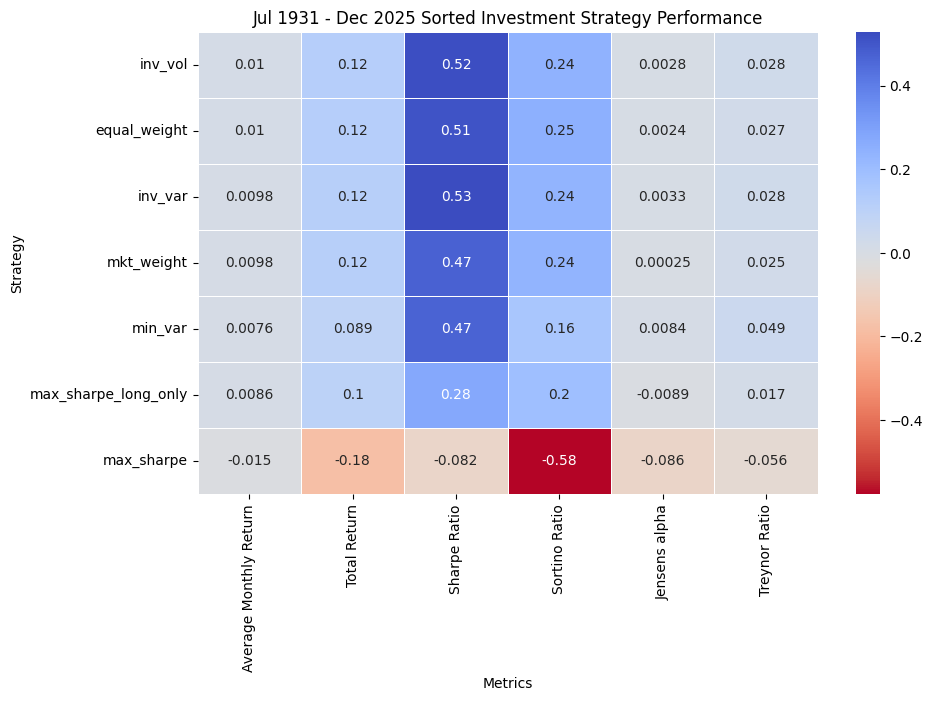

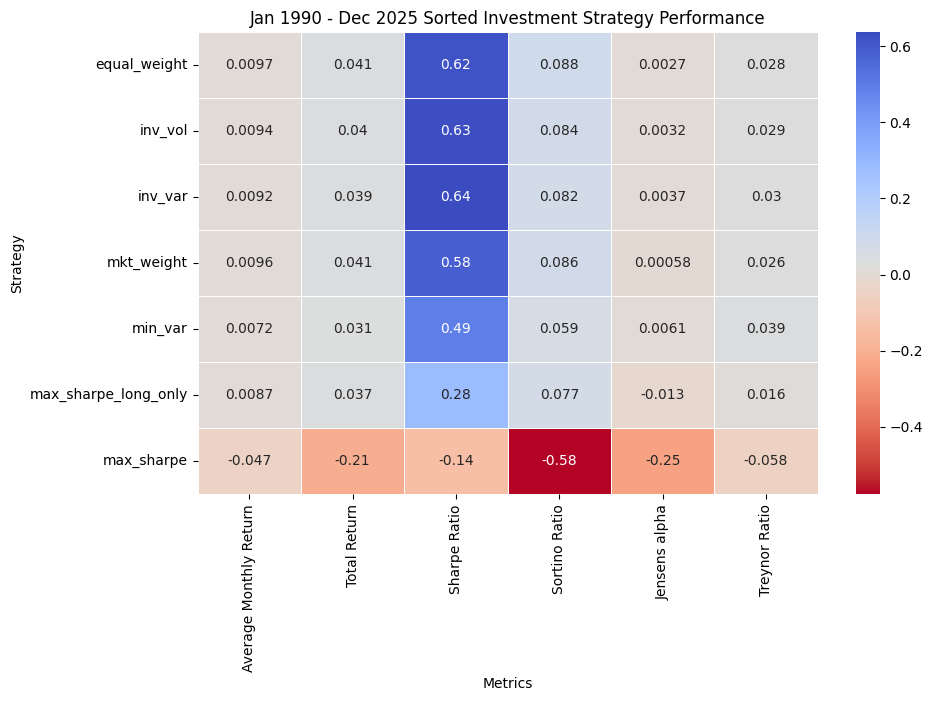

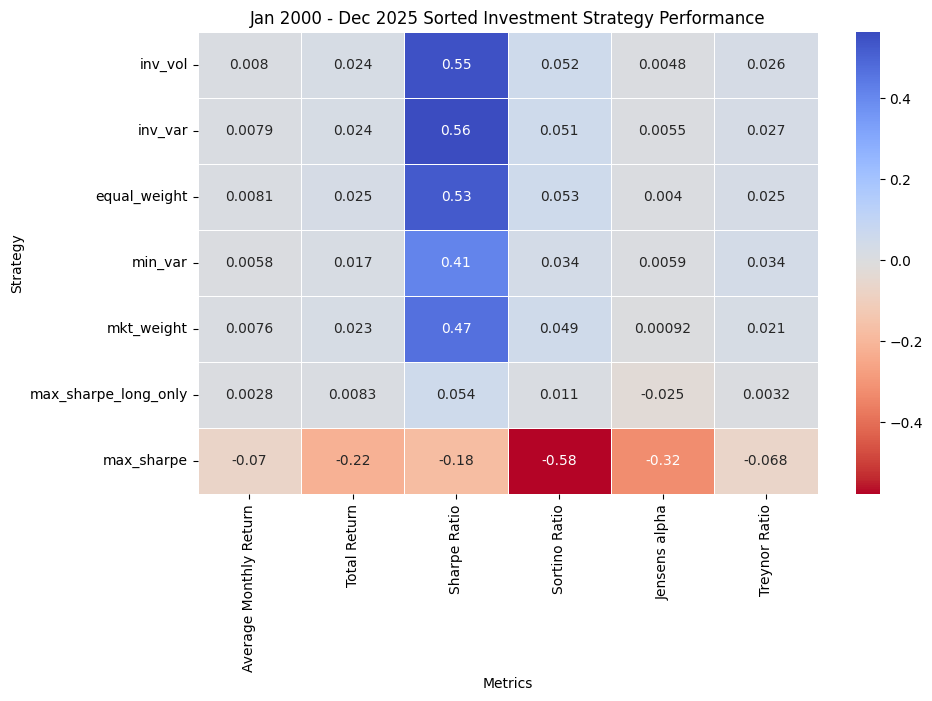

In [137]:
# Rank and Plot each strategy for each time period

periods = ['Jul 1931 - Dec 2025','Jan 1990 - Dec 2025','Jan 2000 - Dec 2025']
for i in periods:
    graph = combined_performance[i]


    graph = graph.apply(pd.to_numeric, errors='coerce')


    # Rank the DataFrame after setting "Strategy" as the index
    df_ranked = graph.rank(ascending=False, method="dense")

    # Sum the ranks for each strategy to get an overall performance score
    df_ranked["Total Rank"] = df_ranked.sum(axis=1)

    # Sort strategies based on their total rank (ascending: best first)
    sorted_index = df_ranked.sort_values(by="Total Rank").index

    # Sort the original data based on the ranked order
    df_sorted_original = graph.loc[sorted_index]


    # Create a heatmap with sorted strategies but retaining original values
    plt.figure(figsize=(10, 6))
    
    sns.heatmap(df_sorted_original, annot=True, cmap="coolwarm_r", linewidths=0.5)

    # Title and labels
    plt.title(f"{i} Sorted Investment Strategy Performance")
    plt.ylabel("Strategy")
    plt.xlabel("Metrics")

    # Display the plot
    plt.show()

